In [1]:
# set up spark
import sys
sys.path += ['/opt/apache-spark/python/lib/py4j-0.10.1-src.zip','/opt/apache-spark/python/lib/pyspark.zip']
from pyspark import *
from pyspark.sql import *
spark = SparkSession.builder.getOrCreate()

import matplotlib.pyplot as plt
import numpy as np
%pylab inline

# set up rdkit
from rdkit import Chem
from rdkit.Chem import Draw

def plotsmiles(smiles1,smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    img = Draw.MolsToImage([mol1,mol2])
    return np.asarray(img)

Populating the interactive namespace from numpy and matplotlib


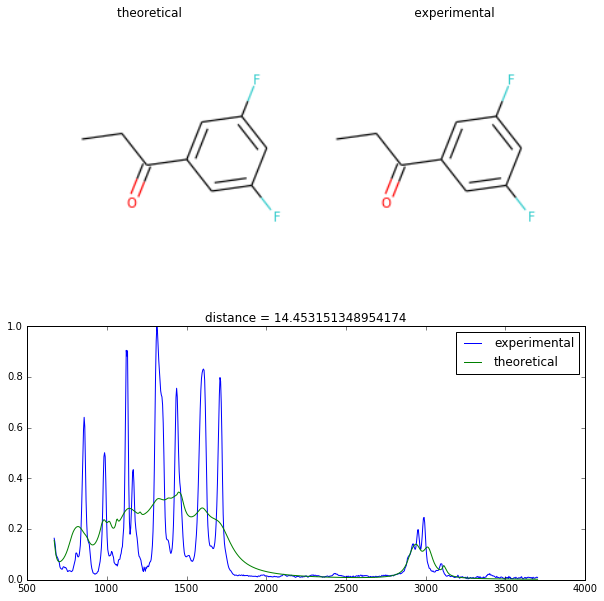

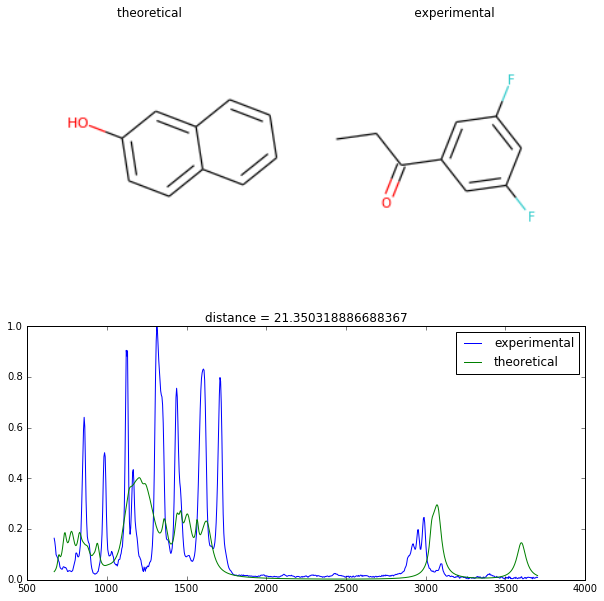

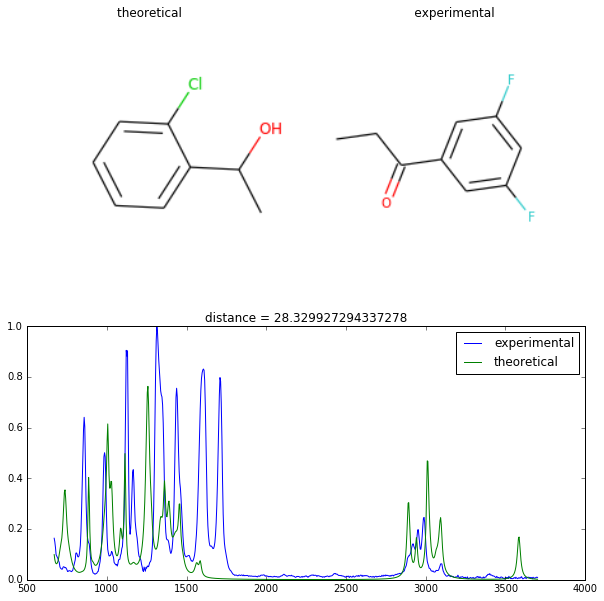

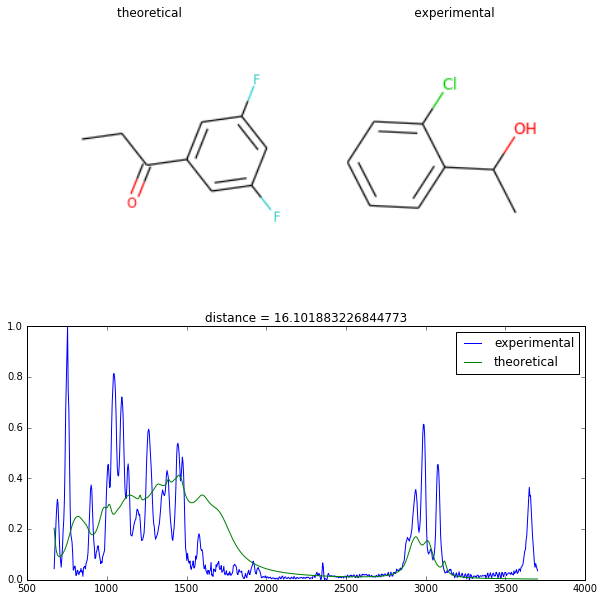

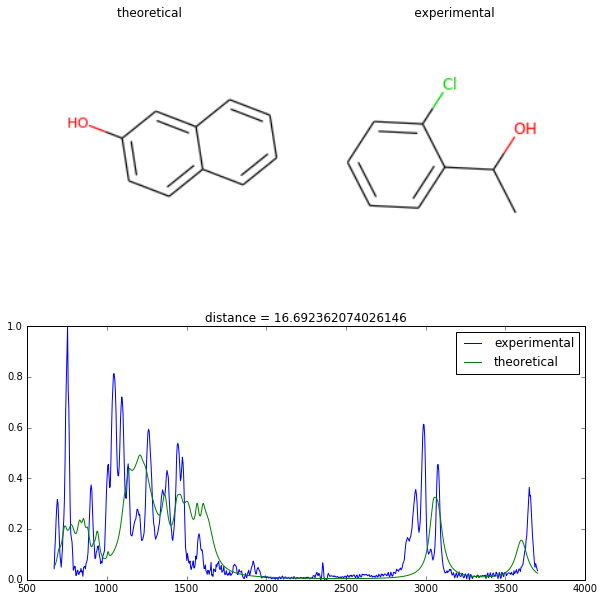

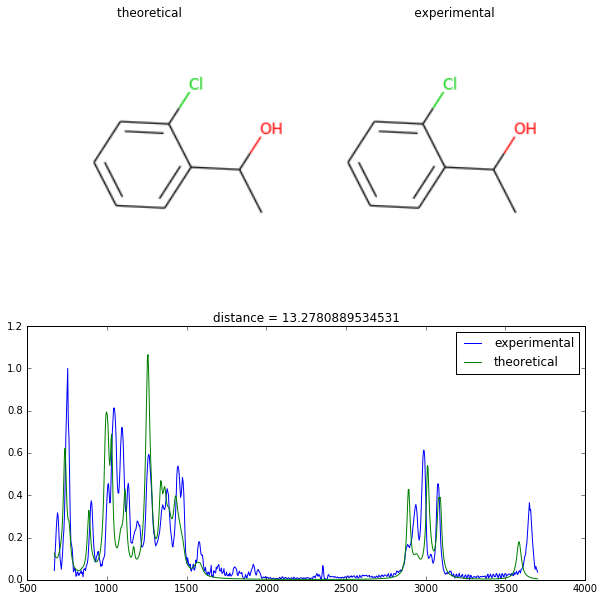

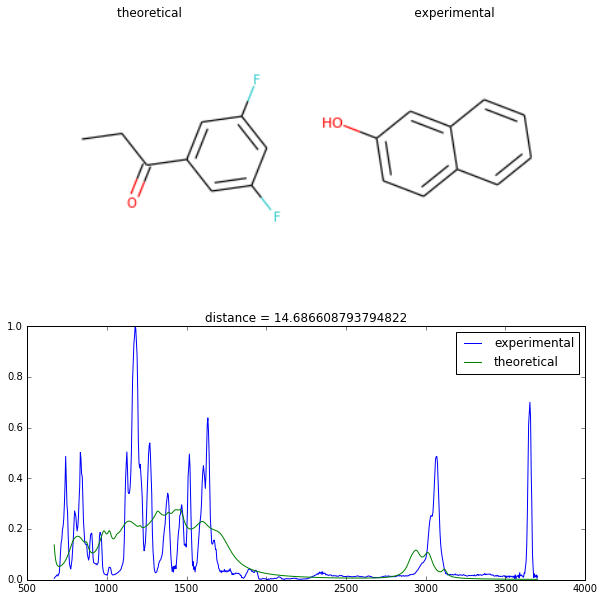

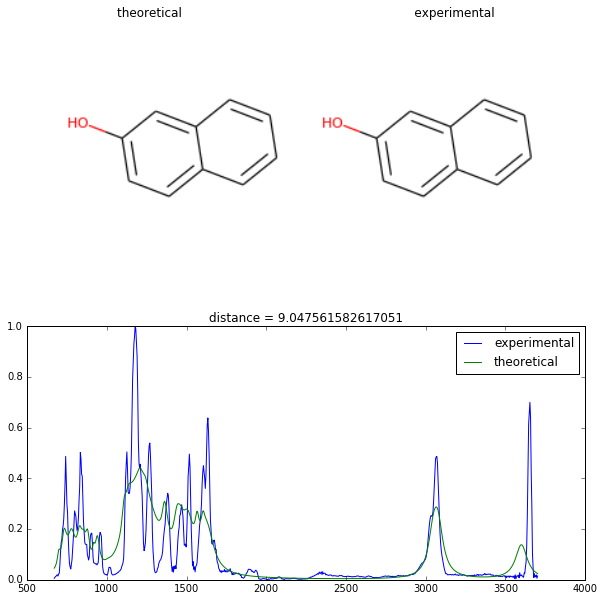

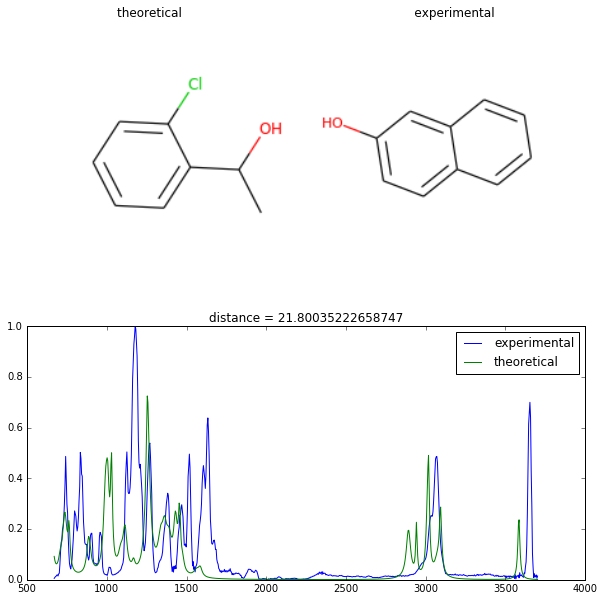

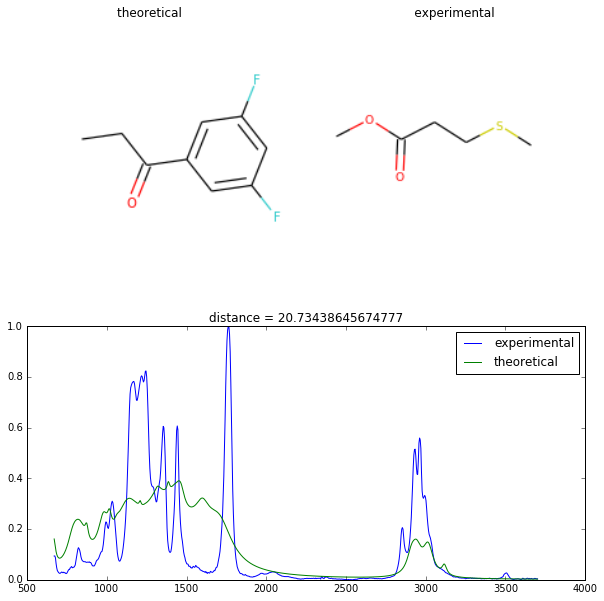

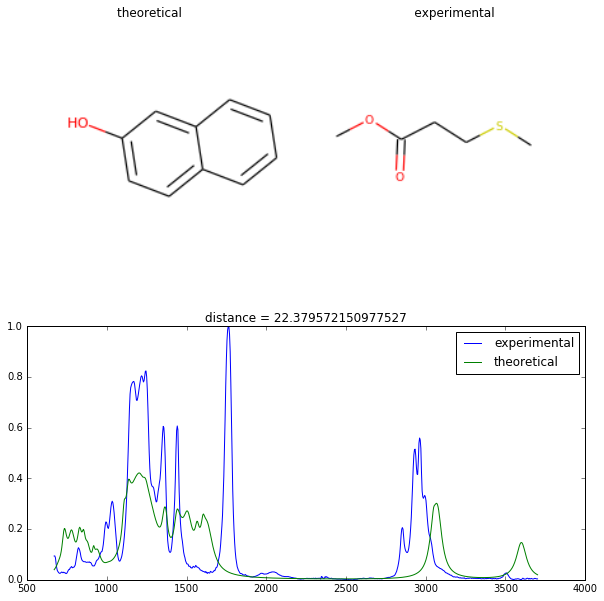

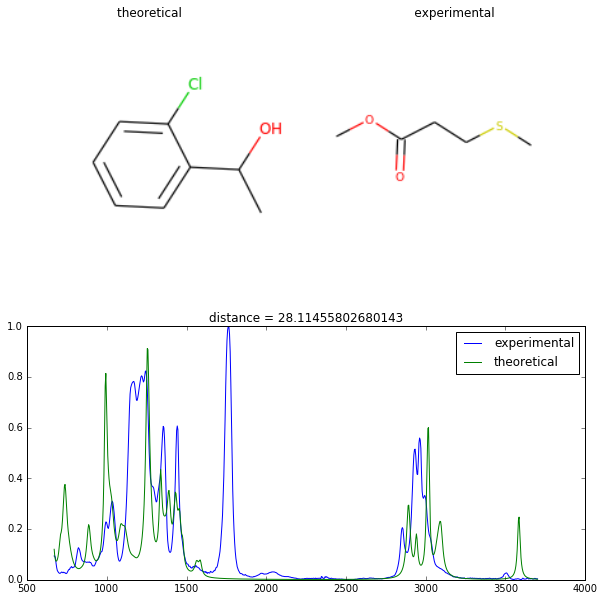

In [3]:
path = '/home/gaoxiang/irms/exp-th-distance'
distances = spark.read.parquet(path+'/distances')
local = distances.collect()
xs = range(670,3706,4)
for row in local:
    th_smiles = row['th_smiles']
    exp_smiles = row['exp_smiles']
    distance = row['distance']
    expvec = row['expvec']
    thvec = row['thvec']
    plt.figure(figsize=(10,10))
    plt.subplot(2, 1, 1)
    plt.axis('off')
    plt.imshow(plotsmiles(th_smiles,exp_smiles))
    plt.title("theoretical                                                            experimental")
    plt.subplot(2, 1, 2)
    plt.plot(xs,expvec,label='experimental')
    plt.plot(xs,thvec,label='theoretical')
    plt.legend()
    plt.title('distance = {}'.format(distance))
    plt.show()